In [1]:
import numpy as np
import pandas as pd
import zipfile as zf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import matplotlib.colors as mcolors

from matplotlib.lines import Line2D

from scipy import stats

# US Baby Names data

In [2]:
ds= zf.ZipFile('data/NationalNames.zip')

names= pd.read_csv(ds.open('NationalNames.csv'))
names= names.drop('Id', axis= 1)
names.head()

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Anna,1880,F,2604
2,Emma,1880,F,2003
3,Elizabeth,1880,F,1939
4,Minnie,1880,F,1746


In [3]:
print(np.round(names.memory_usage().sum() / 10**6, 2), "MB")

58.41 MB


In [4]:
most_frequent= (names.groupby(['Name', 'Gender'])['Count'].sum().reset_index()).sort_values('Count', 
                                                                                          ascending=False)
most_frequent= (most_frequent.reset_index(drop=True)).loc[:5,:]
most_frequent

,Name,Gender,Count
0,James,M,5105919
1,John,M,5084943
2,Robert,M,4796695
3,Michael,M,4309198
4,Mary,F,4115282
5,William,M,4055473


In [59]:
name_list= ['Ashley', 'Amanda', 'Jessica', 'Patricia', 'Linda', 'Deborah', 'Dorothy', 'Betty', 'Helen']

In [138]:
# For selecting the names time series from data and reshaping data format to years x names 

date= np.asarray(names['Year'].unique())

ts_reshaped= np.zeros((len(date), len(name_list)))

for i in range(ts_reshaped.shape[0]):
    temp_y= names.loc[names['Year']== date[i]]
    
    for j in range(ts_reshaped.shape[1]):
        
        try:
            count= (temp_y.loc[(temp_y['Name']== (name_list[j])) & 
                               (temp_y['Gender']== ('F'))])

            count= np.asarray(count['Count'])[0]
        except:
            count= 0
        
        ts_reshaped[i][j]= count

In [61]:
ts_names= pd.concat([pd.DataFrame(data= date, columns=['Year']), 
                     pd.DataFrame(data= ts_reshaped, columns= name_list)], axis=1)

ts_names.head()

,Year,Ashley,Amanda,Jessica,Patricia,Linda,Deborah,Dorothy,Betty,Helen
0,1880,0.0,241.0,7.0,0.0,27.0,12.0,112.0,117.0,636.0
1,1881,0.0,263.0,7.0,0.0,38.0,14.0,109.0,112.0,612.0
2,1882,0.0,288.0,8.0,0.0,36.0,15.0,115.0,123.0,838.0
3,1883,0.0,287.0,6.0,0.0,49.0,16.0,141.0,120.0,862.0
4,1884,0.0,337.0,14.0,6.0,33.0,13.0,163.0,144.0,986.0


In [62]:
y_values= [np.asarray((ts_names.T).iloc[i,0:ts_names.shape[0]], dtype=int) for i in range(1,ts_names.shape[1])]

In [81]:
# For curves with gaussian smoothing

def gaussian_smooth(x, y, grid, sd):
    weights= np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights= weights / weights.sum(0)
    
    return (weights * y).sum(1)

In [128]:
PALETTE= list((mcolors.TABLEAU_COLORS).values())
DARKG= "#111111"

# Stacked graph

Text(0.52, 0.95, 'US baby names - trends over time')

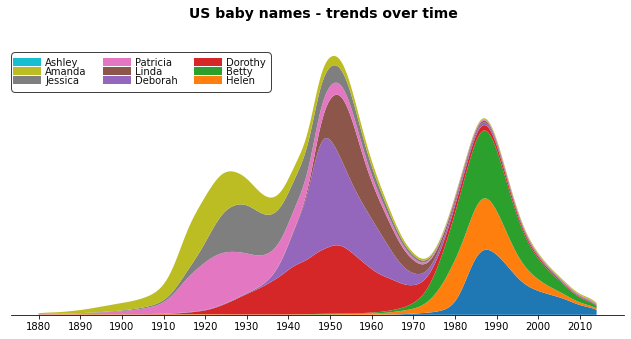

In [139]:
fig, ax= plt.subplots(figsize=(11, 5))

# Generate a grid with 10k samples between max and min years for smoothing
grid= np.linspace(ts_names['Year'].min(), ts_names['Year'].max(), num=10000)
values_smoothed= [gaussian_smooth(np.asarray(ts_names['Year']), y, grid, sd=2) for y in y_values]

ax.stackplot(grid, values_smoothed, colors=PALETTE)

ax.xaxis.set_ticks(np.arange(ts_names['Year'].min(), ts_names['Year'].max(), 10))
ax.yaxis.set_visible(False)

# Also remove spines
ax.spines["left"].set_color("none")
#ax.spines["bottom"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Creates each handle for the legend
def get_handle(label, color):
    line = Line2D( [0], [0], color=color, label=label, lw=8 )
    
    return line

# Create the handles
handles = [get_handle(name_list, color) for name_list, color in zip(name_list, PALETTE[::-1])]

legend= fig.legend(
    handles=handles,
    bbox_to_anchor=[0.29, 0.8], # Legend location.
    edgecolor=DARKG,
    labelspacing=-0.1,
    loc="center", 
    ncol=3
)

# Change size and color of legend labels
for text in legend.get_texts():
    text.set_fontsize(10)   
    text.set_color(DARKG)

# For a rounded appearence to the frame of the legend
legend.get_frame().set_boxstyle("round", rounding_size=0.4, pad=0.2)

fig.text(
    0.52, 0.95,
    'US baby names - trends over time', fontsize=14, fontweight="bold", ha="center"
)

#plt.savefig('stacked.pdf', pad_inches=0.01, bbox_inches="tight")

In [137]:
# This document was partialy inspired on X-Men comics exploration by Yan Holtz
# https://python-graph-gallery.com/web-streamchart-with-matplotlib/